[![Open In Colab](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/badge/open-in-colab.svg)](https://colab.research.google.com/github/crunchdao/quickstarters/blob/master/competitions/structural-break/quickstarters/baseline/baseline.ipynb)
[![Open In Kaggle](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/badge/open-in-kaggle.svg)](https://www.kaggle.com/code/crunchdao/structural-break-baseline)

![Banner](https://raw.githubusercontent.com/crunchdao/quickstarters/refs/heads/master/competitions/structural-break/assets/banner.webp)

# ADIA Lab Structural Break Challenge

## Challenge Overview

Welcome to the ADIA Lab Structural Break Challenge! In this challenge, you will analyze univariate time series data to determine whether a structural break has occurred at a specified boundary point.

### What is a Structural Break?

A structural break occurs when the process governing the data generation changes at a certain point in time. These changes can be subtle or dramatic, and detecting them accurately is crucial across various domains such as climatology, industrial monitoring, finance, and healthcare.

![Structural Break Example](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/structural-break/quickstarters/baseline/images/example.png)

### Your Task

For each time series in the test set, you need to predict a score between `0` and `1`:
- Values closer to `0` indicate no structural break at the specified boundary point;
- Values closer to `1` indicate a structural break did occur.

### Evaluation Metric

The evaluation metric is [ROC AUC (Area Under the Receiver Operating Characteristic Curve)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), which measures the performance of detection algorithms regardless of their specific calibration.

- ROC AUC around `0.5`: No better than random chance;
- ROC AUC approaching `1.0`: Perfect detection.

# Setup

The first steps to get started are:
1. Get the setup command
2. Execute it in the cell below

### >> https://hub.crunchdao.com/competitions/structural-break/submit/notebook

![Reveal token](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/reveal-token.gif)

In [9]:
%pip install crunch-cli --upgrade --quiet --progress-bar off
!crunch setup-notebook structural-break bEa6KXcZo6gop69GJ1U6jT7Z

crunch-cli, version 7.5.0
you appear to have never submitted code before
data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
                                
---
Success! Your environment has been correctly setup.
Next recommended actions:
1. Load the Crunch Toolings: `crunch = crunch.load_notebook()`
2. Execute the cells with your code
3. Run a test: `crunch.test()`
4. Download and submit your code to t

In [10]:
import crunch
crunch = crunch.load_notebook()


loaded inline runner with module: <module '__main__'>

cli version: 7.5.0
available ram: 12.67 gb
available cpu: 2 core
----


In [17]:
import os
print(os.listdir())


['.config', '.crunchdao', 'resources', 'data', 'sample_data']


In [18]:
!find / -type d -name "structural-break" 2>/dev/null | head -n 10


In [11]:
import numpy as np
import pandas as pd
import joblib
import os
import typing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy import stats, signal

# ---------- Feature extraction ----------
def extract_features(df: pd.DataFrame) -> pd.Series:
    pre = df[df["period"] == 0]["value"].values
    post = df[df["period"] == 1]["value"].values

    def safe_stat(x, func, default=0.0):
        try:
            return func(x)
        except Exception:
            return default

    # Rolling stats (window ~ 50 if enough points)
    def rolling_var(x, w=50):
        if len(x) < w:
            return np.var(x)
        return pd.Series(x).rolling(w).var().dropna().mean()

    # FFT energy
    def fft_energy(x):
        if len(x) == 0:
            return 0
        fft_vals = np.abs(np.fft.rfft(x))
        return np.sum(fft_vals**2)

    # Autocorr
    def autocorr(x, lag=1):
        if len(x) <= lag:
            return 0
        return np.corrcoef(x[:-lag], x[lag:])[0,1]

    features = {
        # Basic stats
        "mean_diff": safe_stat(post, np.mean) - safe_stat(pre, np.mean),
        "var_diff": safe_stat(post, np.var) - safe_stat(pre, np.var),
        "median_diff": np.median(post) - np.median(pre),

        # Higher moments
        "skew_diff": safe_stat(post, pd.Series(post).skew) - safe_stat(pre, pd.Series(pre).skew),
        "kurt_diff": safe_stat(post, pd.Series(post).kurt) - safe_stat(pre, pd.Series(pre).kurt),

        # Rolling variance
        "rollvar_diff": rolling_var(post) - rolling_var(pre),

        # Autocorr
        "autocorr_diff": autocorr(post) - autocorr(pre),

        # FFT energy
        "fft_energy_diff": fft_energy(post) - fft_energy(pre),

        # KS test statistic (two-sample distribution test)
        "ks_stat": stats.ks_2samp(pre, post).statistic if len(pre) > 0 and len(post) > 0 else 0,

        # CUSUM (cumulative sum of mean differences)
        "cusum_stat": np.max(np.abs(np.cumsum(post - np.mean(pre)))) if len(post) > 0 else 0,
    }

    return pd.Series(features)


# ---------- Training ----------
def train(X_train: pd.DataFrame, y_train: pd.Series, model_directory_path: str):
    # Build dataset of features for each id
    features_list = []
    for idx, df in X_train.groupby("id"):
        feat = extract_features(df)
        feat["id"] = idx
        features_list.append(feat)
    feature_df = pd.DataFrame(features_list).set_index("id")

    # Align with y_train
    X_feat = feature_df.loc[y_train.index]
    y = y_train.astype(int)

    # Build pipeline: scaling + logistic regression
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000))
    ])

    # Train
    model.fit(X_feat, y)

    # Save
    joblib.dump(model, os.path.join(model_directory_path, "model.joblib"))


# ---------- Inference ----------
def infer(X_test: typing.Iterable[pd.DataFrame], model_directory_path: str):
    model = joblib.load(os.path.join(model_directory_path, "model.joblib"))

    yield  # Mark as ready

    for df in X_test:
        feat = extract_features(df).values.reshape(1, -1)
        # Predict probability of structural break (class 1)
        pred = model.predict_proba(feat)[0, 1]
        yield pred


In [12]:
import os
print(os.listdir())


['.config', '.crunchdao', 'resources', 'data', 'sample_data']


In [13]:
crunch.test()


12:31:57 no forbidden library found
12:31:57 
12:31:57 started
12:31:57 running local test
12:31:57 internet access isn't restricted, no check will be done
12:31:57 
12:31:57 starting unstructured loop...
12:31:57 executing - command=train


data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match


12:33:13 executing - command=infer
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/

In [14]:
import pandas as pd
import sklearn.metrics

prediction = pd.read_parquet("data/prediction.parquet")
target = pd.read_parquet("data/y_test.reduced.parquet")["structural_breakpoint"]

print("Local ROC AUC:", sklearn.metrics.roc_auc_score(target, prediction))


Local ROC AUC: 0.4981220657276995


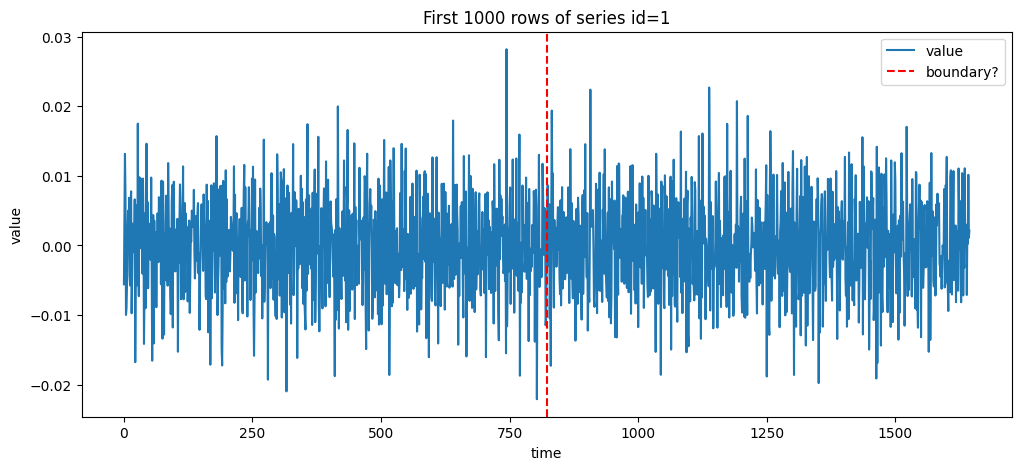

In [25]:
import matplotlib.pyplot as plt

# Select the series with id=0
df_series = X_train.loc[0]

# Take the first 1000 time steps
df_1000 = df_series.head(10000)

# Plot
plt.figure(figsize=(12,5))
plt.plot(df_1000.index, df_1000["value"], label="value")
plt.axvline(df_1000.index.max()/2, color="red", linestyle="--", label="boundary?")
plt.title("First 1000 rows of series id=1")
plt.xlabel("time")
plt.ylabel("value")
plt.legend()
plt.show()


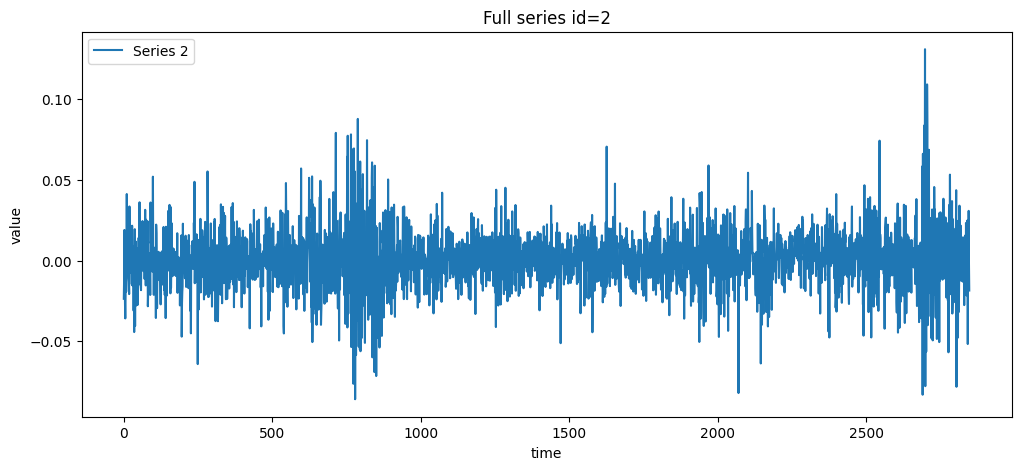

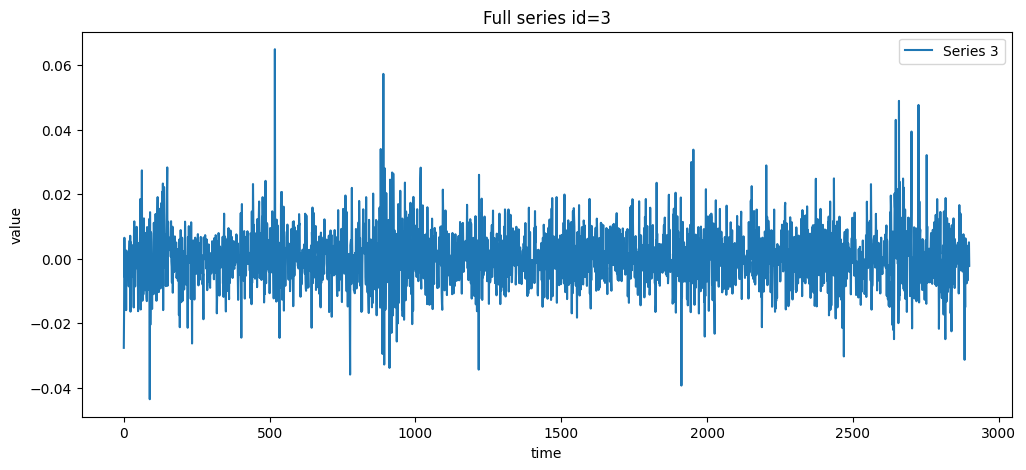

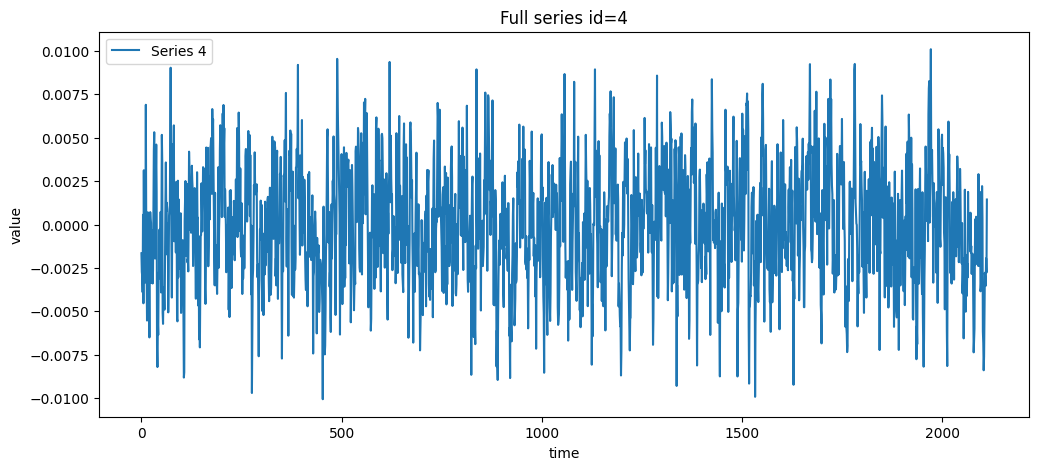

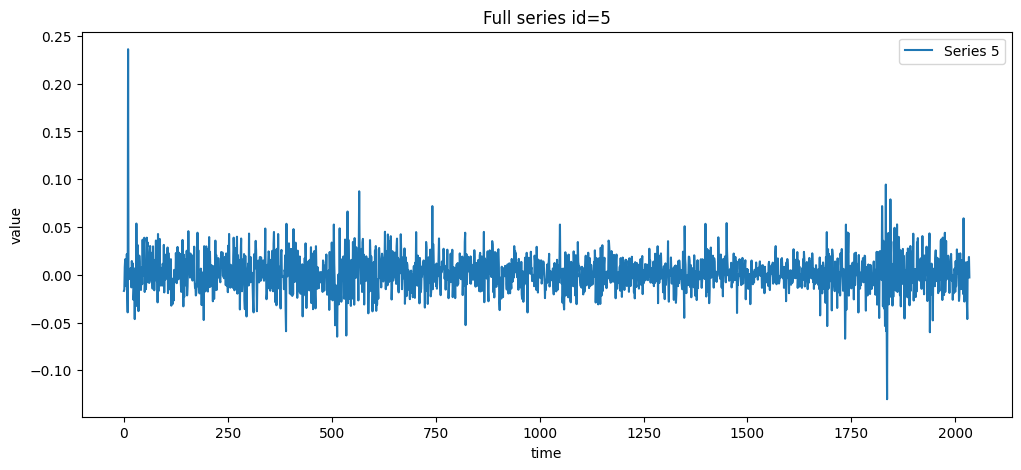

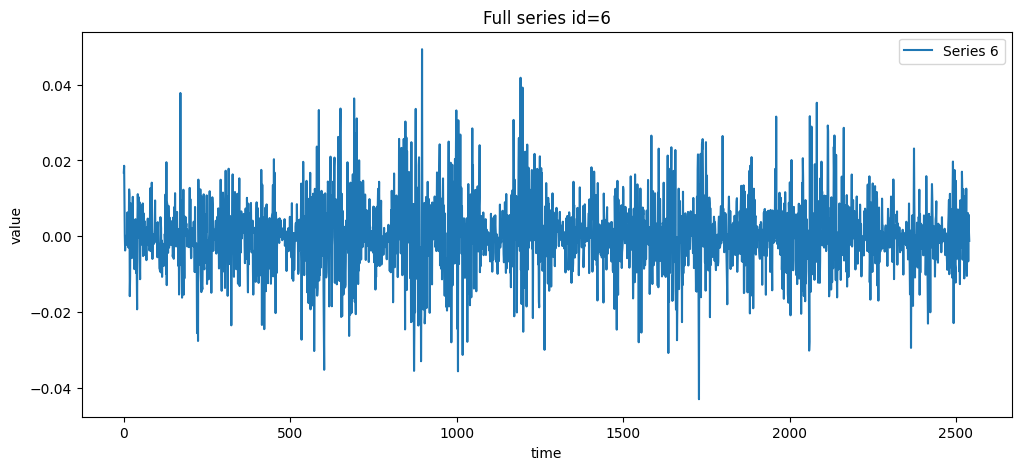

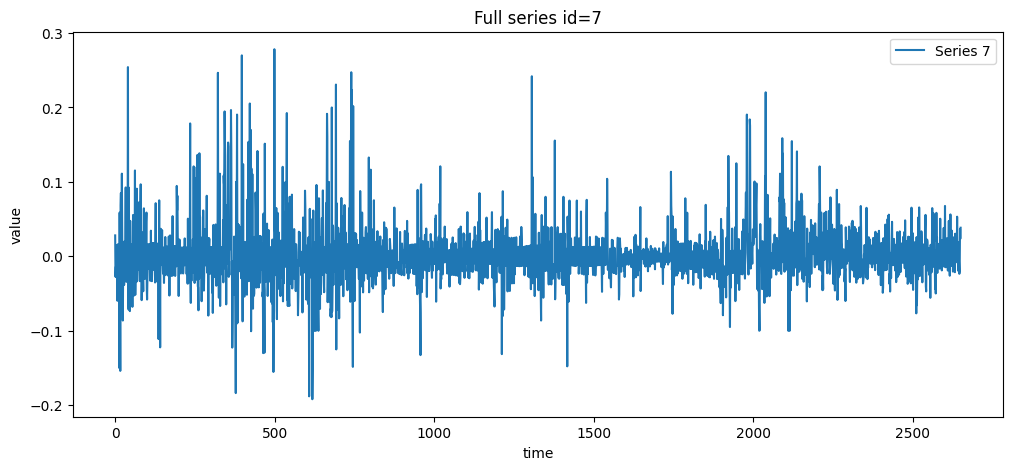

In [26]:
import matplotlib.pyplot as plt

# Loop through series IDs 2 to 7
for sid in range(2, 8):
    df_series = X_train.loc[sid]   # extract series

    plt.figure(figsize=(12,5))
    plt.plot(df_series.index, df_series["value"], label=f"Series {sid}")
    plt.title(f"Full series id={sid}")
    plt.xlabel("time")
    plt.ylabel("value")
    plt.legend()
    plt.show()


In [44]:
X_train.index.unique()

MultiIndex([(    0,    0),
            (    0,    1),
            (    0,    2),
            (    0,    3),
            (    0,    4),
            (    0,    5),
            (    0,    6),
            (    0,    7),
            (    0,    8),
            (    0,    9),
            ...
            (10000, 2129),
            (10000, 2130),
            (10000, 2131),
            (10000, 2132),
            (10000, 2133),
            (10000, 2134),
            (10000, 2135),
            (10000, 2136),
            (10000, 2137),
            (10000, 2138)],
           names=['id', 'time'], length=23715734)

In [56]:
import pandas as pd
import numpy as np

# Initialize list to store results
summary_stats = []

# Loop through series IDs 0 to 9999
for sid in range(10000):
    try:
        df_series = X_train.loc[sid]
        values = df_series["value"].values
        n = len(values)


        if len(values) < 1500:
            continue  # skip very short series

        first = values[0:500]
        second = values[501:1000]
        third = values[1001:1500]
        remaining = values[1501:]

        summary_stats.append({
            "series_id": sid,
            "n": n,
            "mean_first": np.mean(first),
            "std_first": np.std(first),
            "mean_second": np.mean(second),
            "std_second": np.std(second),
            "mean_third": np.mean(third),
            "std_third": np.std(third),
            "mean_remaining": np.mean(remaining),
            "std_remaining": np.std(remaining)
        })
    except Exception as e:
        print(f"Series {sid} failed: {e}")
        continue

# Convert to DataFrame
stats_df = pd.DataFrame(summary_stats)

# Display first few rows
print(stats_df.head())

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


   series_id     n  mean_first  std_first   mean_second  std_second  \
0          0  1645    0.000008   0.006928 -3.357977e-06    0.006905   
1          1  2529    0.000228   0.002559  1.332839e-04    0.001850   
2          2  2848   -0.000613   0.016063  2.942030e-04    0.024383   
3          3  2900    0.000175   0.008208 -2.852794e-05    0.010354   
4          4  2113   -0.000153   0.003267 -5.087246e-07    0.003252   

   mean_third  std_third  mean_remaining  std_remaining  
0    0.000012   0.007215        0.000087       0.006328  
1    0.000143   0.003707        0.000010       0.001879  
2    0.000626   0.012626        0.001237       0.018384  
3    0.000554   0.007229        0.000518       0.008464  
4    0.000086   0.003333        0.000018       0.003441  


In [46]:
print(stats_df)

      series_id  mean_first  std_first  mean_second  std_second  mean_third  \
0             0   -0.005564        0.0     0.003705         0.0    0.013164   
1             1    0.000470        0.0    -0.000254         0.0    0.000223   
2             2   -0.023663        0.0    -0.012452         0.0    0.018947   
3             3   -0.027626        0.0    -0.016144         0.0    0.006475   
4             4   -0.001656        0.0    -0.002732         0.0   -0.002971   
...         ...         ...        ...          ...         ...         ...   
9995       9995    0.008352        0.0     0.003996         0.0    0.029781   
9996       9996    0.017429        0.0    -0.005088         0.0   -0.008819   
9997       9997   -0.002098        0.0    -0.010571         0.0   -0.009687   
9998       9998    0.000548        0.0     0.007673         0.0   -0.009839   
9999       9999   -0.000327        0.0     0.000491         0.0   -0.000007   

      std_third  mean_remaining  std_remaining  
0 

In [57]:
stats_df.to_csv("series_statistics.csv", index=False)

In [58]:
from google.colab import files
files.download("series_statistics.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
stats_df[stats_df["series_id"] == 7290]


,series_id,n,mean_first,std_first,mean_second,std_second,mean_third,std_third,mean_remaining,std_remaining
7096,7290,1500,-0.000749,0.052842,-0.002132,0.054614,-0.002167,0.060383,NaN,NaN


In [54]:
df = stats_df.copy()

# Compute absolute deltas between consecutive segments
df["mean_delta"] = (
    np.abs(df["mean_second"] - df["mean_first"]) +
    np.abs(df["mean_third"] - df["mean_second"]) +
    np.abs(df["mean_remaining"] - df["mean_third"])
)

df["std_delta"] = (
    np.abs(df["std_second"] - df["std_first"]) +
    np.abs(df["std_third"] - df["std_second"]) +
    np.abs(df["std_remaining"] - df["std_third"])
)

# Combine into a single volatility score
df["volatility_score"] = df["mean_delta"] + df["std_delta"]

# Sort and select top 100
top_100 = df.sort_values(by="volatility_score", ascending=False).head(100)

# Display key columns
print(top_100[["series_id", "volatility_score", "mean_delta", "std_delta"]])

      series_id  volatility_score  mean_delta  std_delta
9694       9961         38.519023    1.640600  36.878423
5673       5823          5.237670    0.213779   5.023891
2791       2859          4.985032    0.494830   4.490202
2519       2585          3.433874    0.469394   2.964480
6346       6520          3.207660    0.173212   3.034448
...         ...               ...         ...        ...
8110       8331          0.111536    0.013099   0.098438
8245       8467          0.110933    0.003901   0.107031
3702       3793          0.110768    0.013092   0.097676
1487       1531          0.109997    0.001958   0.108038
5066       5203          0.109952    0.009835   0.100117

[100 rows x 4 columns]


In [63]:
top_100.to_csv("top_100_volatility_series.csv", index=False)

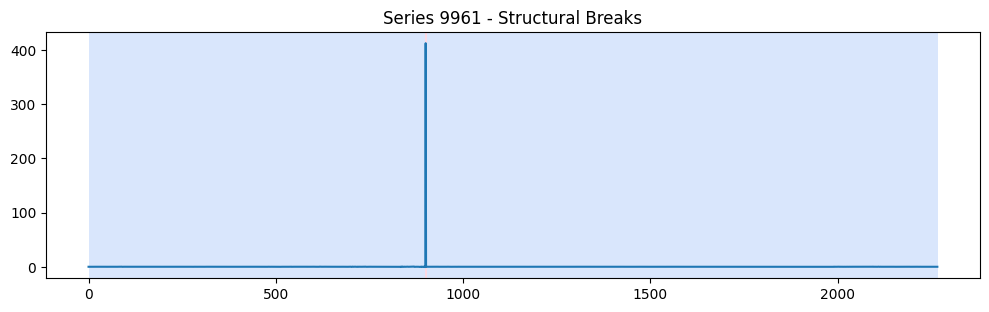

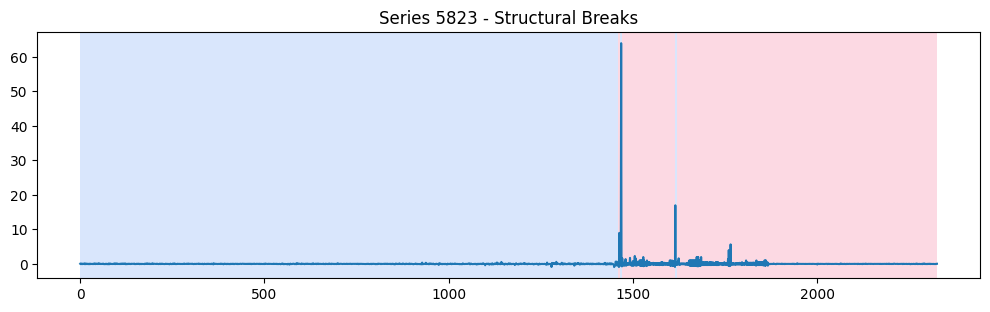

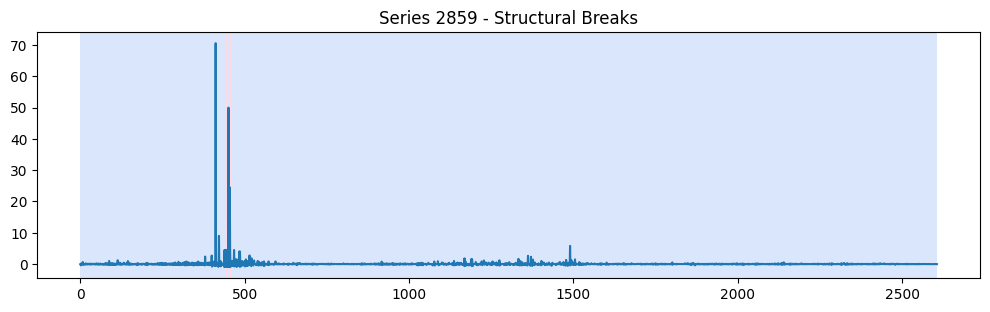

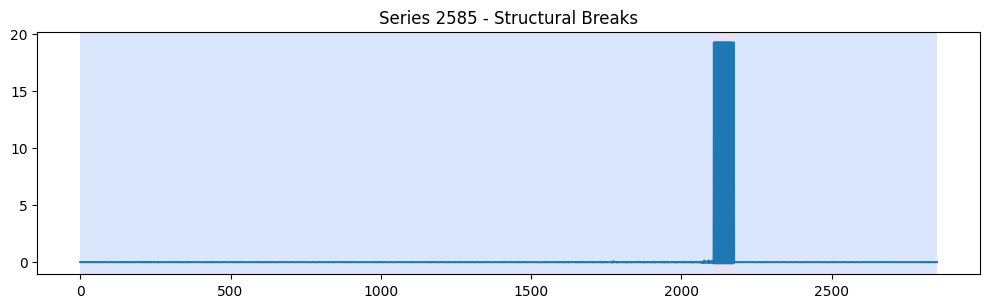

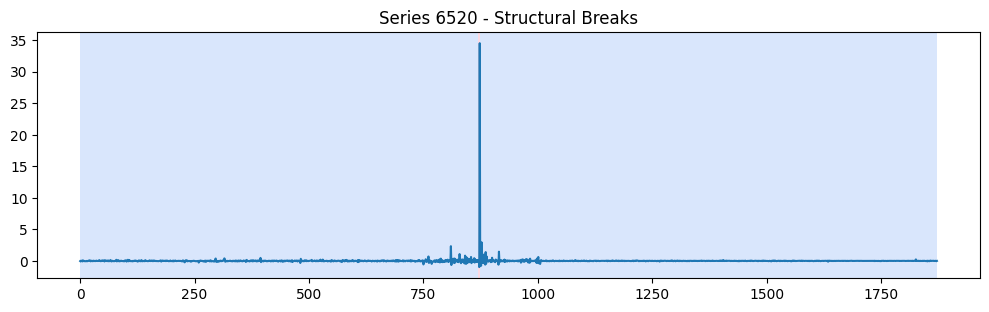

In [65]:
import ruptures as rpt
import matplotlib.pyplot as plt

# Extract top 5 series IDs
top_5_ids = top_100["series_id"].head(5).tolist()

# Store results
break_results = []

for sid in top_5_ids:
    try:
        # Extract series data
        df_series = X_train.loc[sid]
        signal = df_series["value"].values

        # Choose model and algorithm
        model = "l2"  # good for detecting mean shifts
        algo = rpt.Pelt(model=model).fit(signal)

        # Predict breakpoints using penalty
        breakpoints = algo.predict(pen=10)  # adjust pen for sensitivity

        # Store results
        break_results.append({
            "series_id": sid,
            "n_points": len(signal),
            "n_breaks": len(breakpoints) - 1,
            "breakpoints": breakpoints
        })

        # Optional: visualize
        rpt.display(signal, breakpoints, figsize=(10, 3))
        plt.title(f"Series {sid} - Structural Breaks")
        plt.show()

    except Exception as e:
        print(f"Series {sid} failed: {e}")
        continue

In [ ]:
import numpy as np
import pandas as pd
import ruptures as rpt
from scipy.stats import zscore
import matplotlib.pyplot as plt

# Extract top 20 series IDs
top_20_ids = top_100["series_id"].head(20).tolist()

# Store results
break_analysis = []

for sid in top_20_ids:
    try:
        df_series = X_train.loc[sid]
        signal = df_series["value"].values
        n = len(signal)

        # Z-score based outlier detection
        z_scores = zscore(signal)
        outlier_mask = np.abs(z_scores) > 3
        outlier_indices = np.where(outlier_mask)[0]

        # Remove outliers for break detection
        clean_signal = signal.copy()
        clean_signal[outlier_mask] = np.nan
        clean_signal = pd.Series(clean_signal).interpolate().fillna(method="bfill").fillna(method="ffill").values

        # Structural break detection
        model = "l2"
        algo = rpt.Pelt(model=model).fit(clean_signal)
        breakpoints = algo.predict(pen=10)

        # Segment-wise stats
        segments = np.split(clean_signal, breakpoints[:-1])
        segment_means = [np.mean(seg) for seg in segments]
        segment_stds = [np.std(seg) for seg in segments]

        # Classification logic
        mean_spread = np.std(segment_means)
        std_spread = np.std(segment_stds)

        if len(outlier_indices) >= 1 and mean_spread < 1.0 and std_spread < 1.0:
            label = "outlier-driven"
        elif len(breakpoints) - 1 >= 2 and (mean_spread >= 1.0 or std_spread >= 1.0):
            label = "structural-break"
        else:
            label = "uncertain"

        break_analysis.append({
            "series_id": sid,
            "n_points": n,
            "n_outliers": len(outlier_indices),
            "n_breaks": len(breakpoints) - 1,
            "mean_spread": round(mean_spread, 3),
            "std_spread": round(std_spread, 3),
            "classification": label,
            "breakpoints": breakpoints
        })

        # Optional: visualize
        plt.figure(figsize=(10, 3))
        rpt.display(clean_signal, breakpoints)
        plt.title(f"Series {sid} - {label}")
        plt.show()

    except Exception as e:
        print(f"Series {sid} failed: {e}")
        continue

# Convert to DataFrame
classification_df = pd.DataFrame(break_analysis)
print(classification_df)